# Project 3
Fraud detection. Using dataset from Kaggle.

## Importing Modules

In [99]:
from bs4 import BeautifulSoup
from random import randint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
import time
import pickle
import os
import datetime
import seaborn as sns
import math
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve

from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

import pymysql.cursors
import sys

#to speed up pandas operands
from pandarallel import pandarallel

#GPU

import cupy as cnp
import cudf
import numpy as np
import pandas as pd
import datetime as dt
import gc
from sklearn.preprocessing import LabelEncoder
from cuml import train_test_split as gputrain_test_split
from cuml import LinearRegression as gpuLinearRegression
from cuml import KMeans as gpuKmeans
from cuml import LogisticRegression as gpuLogisticRegression
from cuml.ensemble import RandomForestClassifier as gpuRandomForestClassifier

In [5]:
#Constants
RANDOM_STATE = 999
TEST_SIZE = 0.1

#set this to 1 if you want to see this
#notebook create the table and import the CSV into the table
#on the My SQL server
RUN_TABLE_CREATE_IMPORT = 0

In [6]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

## Data Download and Load Into SQL

Note if you want a copy of the data you can download it from [here](https://www.kaggle.com/ntnu-testimon/paysim1) 

In [7]:
#just reading enough to get the names of the columns
data_df = pd.read_csv("../Data/PS_20174392719_1491204439457_log.csv",nrows=5)

In [8]:
#Getting column names
COL_NAMES = data_df.columns
COL_NAMES = list(COL_NAMES)
COL_NAMES.remove("type")
COL_NAMES.append("transtype")
for i, a_col in enumerate(COL_NAMES):
    print(a_col)

step
amount
nameOrig
oldbalanceOrg
newbalanceOrig
nameDest
oldbalanceDest
newbalanceDest
isFraud
isFlaggedFraud
transtype


In [9]:
#What type of data is in each column?
data_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [10]:
#Establishing connection to mariaDB server
#Note, sever_details.txt is not provided you'll have to ask me for it
if sys.platform == 'linux':
    server_details_file_name = "/home/magreen/Dropbox/PERSONAL/Documents/Word/server_details.txt"
elif sys.platform == 'darwin':
    server_details_file_name = "/Users/magreen/Dropbox/PERSONAL/Documents/Word/server_details.txt"
else:
    print("WARNING: You are running on a system type I have not tested. Please contact me if you want help testing this.")

SERVER_DETAILS = open(server_details_file_name,"r")
line_of_text = SERVER_DETAILS.readline()

host_name, username, mypassword, db_name = line_of_text.split(',')

host_name = host_name.rstrip()
host_name = host_name.lstrip()
username = username.rstrip()
username = username.lstrip()
mypassword = mypassword.rstrip()
mypassword = mypassword.lstrip()
db_name = db_name.rstrip()
db_name = db_name.lstrip()


In [11]:
data_df = None

In [12]:
connection = pymysql.connect(host=host_name, user=username, password=mypassword, db=db_name, cursorclass=pymysql.cursors.DictCursor)

In [13]:
#get a cursor
mycursor = connection.cursor()

In [14]:
#Create table import entire CSV
if RUN_TABLE_CREATE_IMPORT != 0:
    drop_table_query = "drop table if exists paysim_data2;"

    mycursor.execute(drop_table_query)
    mycursor.execute("commit;")

    create_table_query = """


create table paysim_data2 (
    step INT,
    transtype VARCHAR(255),
    amount REAL,
    nameOrig VARCHAR(255),
    oldbalanceOrg REAL,
    newbalanceOrig REAL,
    nameDest VARCHAR(255),
    oldbalanceDest REAL,
    newbalanceDest REAL,
    isFraud INT,
    isFlaggedFraud INT
    );


    """
    mycursor.execute(create_table_query)
    mycursor.execute("commit;")

    import_query = """


load data infile '/var/lib/mysql-files/data/PS_20174392719_1491204439457_log.csv'
into table paysim_data2 fields terminated by ','  lines terminated by '\n'
ignore 1 rows;

    """

    mycursor.execute(import_query)
    mycursor.execute("commit;")
    
    #and a row ID to the table
    alter_table_query = """
    alter table paysim_data2 add column id int auto_increment primary key first;
    """
    mycursor.execute(alter_table_query)
    mycursor.execute("commit;")
    print("table creation and import done")
else:
    print("Skipping MySQL table creation and CSV import")

Skipping MySQL table creation and CSV import


## Data Cleaning

In this section I remove rows that contain null entries or duplicate entries from the SQL table.

In [15]:
##Things I'm doing to test my data cleaning in SQL
add_some_duplicates_nulls_query = """

insert into paysim_data2(step, transtype, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest,isFraud,isFlaggedFraud) values(1,'PAYMENT',55,'Han Solo',100.0,45,'Princess Lea',0,55,0,0);
insert into paysim_data2(step, transtype, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest,isFraud,isFlaggedFraud) values(1,'PAYMENT',55,'Han Solo',100.0,45,'Princess Lea',0,55,0,0);


insert into paysim_data2(step, transtype, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest,isFraud,isFlaggedFraud) values(1,'PAYMENT',NULL,'C3PO',100.0,45,'R2D2',0,55,0,0);
insert into paysim_data2(step, transtype, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest,isFraud,isFlaggedFraud) values(1,'PAYMENT',10,'Luke',100.0,90,'Wedge',0,NULL,0,0);



"""
#mycursor.execute(add_some_duplicates_nulls_query)
#mycursor.execute("commit;")


In [16]:
########################################################################
#
# Search each column in the MySQL table for null. If null remove the row
#
########################################################################
if RUN_TABLE_CREATE_IMPORT != 0:

    for column_name in COL_NAMES:
        temp_query = """
    
        select * from paysim_data2 where {} is null;
    
        """.format(column_name)
    
        mycursor.execute("begin;")
        query_result = mycursor.execute(temp_query)
        print("For column = {} here are the null rows:\n".format(column_name))
        print(query_result)
        print("\n")
    
        if query_result != 0:
            row_contents = mycursor.fetchall()
            print("This row contains NULL information:\n")
        
            for bad_row in row_contents:
                print(row_contents)
            
            temp_efface_row_query = """
            delete from paysim_data2 where {} is null;
            """.format(column_name)
        
            query_result = mycursor.execute(temp_efface_row_query)
        
            #print("result = {}".format(query_result))
            mycursor.execute("commit;")
            #print("result = {}".format(query_result))
            if query_result:
                print("\nsuccessfully removed row\n")
            else:
                print("error: failed to remove row!")
        
    

        
    print("\ncheck done.\n")
else:
    print("\nskipping null search and clean\n")

#import CSV Into SQL Table



skipping null search and clean



In [17]:
########################################################################
#
# Search for duplicate rows. Remove the second-most row for every pair of duplicate rows
#
########################################################################

search_for_duplicates_query = """
select
     step, count(step),
     transtype, count(transtype),
     amount, count(amount),
     nameOrig, count(nameOrig),
     oldbalanceOrg, count(oldbalanceOrg),
     newbalanceOrig, count(newbalanceOrig),
     nameDest, count(nameDest),
     oldbalanceDest, count(oldbalanceDest),
     newbalanceDest, count(newbalanceDest),
     isFraud, count(isFraud),
     isFlaggedFraud, count(isFlaggedFraud)
     from paysim_data2
     group by step,transtype,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
     having
     count(step) > 1 and
     count(transtype) > 1 and
     count(amount) > 1 and
     count(nameOrig) > 1 and
     count(oldbalanceOrg) > 1 and
     count(newbalanceOrig) > 1 and
     count(nameDest) > 1 and
     count(oldbalanceDest) > 1 and
     count(newbalanceDest) > 1 and
     count(isFraud) > 1 and
     count(isFlaggedFraud) > 1;



"""

remove_duplicates_query1 = """


SET SESSION old_alter_table=1;


"""

remove_duplicates_query2 = """

alter ignore table paysim_data2 add unique index u(amount,nameOrig,nameDest);


"""


remove_duplicates_query3 = """
SET SESSION old_alter_table=0;


"""
if RUN_TABLE_CREATE_IMPORT != 0:

    # removing duplicates takes too long will just search for duplicates
    # The dataset has 6M rows every duplicate remove I found 
    # does a n^2 operation which is too many for this DB
    # other methods (CTE) don't work
    mycursor.execute("begin;")
    mycursor.execute(search_for_duplicates_query)
    results = mycursor.fetchall()

    print("following are duplicate rows in the SQL DB:\n")
    for myresult in results:
        print(myresult)
    print("\ndone searching for duplicates\n")

    print("removing duplicates\n")
    mycursor.execute("begin;")
    mycursor.execute(remove_duplicates_query1)
    mycursor.execute("commit;")
    mycursor.execute(remove_duplicates_query2)
    mycursor.execute("commit;")
    mycursor.execute(remove_duplicates_query3)
    mycursor.execute("commit;")
    print("\ndone removing duplicates\n")
else:
    print("\nskipping redundant row search and remove\n")



skipping redundant row search and remove



## EDA

Things I want to do in this section:

* Find a feature / features that enable me to separate the classes
* Create a feature that will enable me to separate the classes
* Determine if the classes are adequately represented in the data set or is this an imbalanced data set


Read the SQL into a data frame

It takes a long time to read from SQL. To make running iterations faster will only run the query based on a parameter

In [18]:
READ_FROM_SQL_SERVER = 0

In [19]:
if READ_FROM_SQL_SERVER:
    get_paysim_data2_table_query = "select * from paysim_data2;"
    paysim_data_df = pd.read_sql(get_paysim_data2_table_query,connection)
    DF_PICKLE_FILE = open("paysim_data_df.pkl","wb")
    pickle.dump(paysim_data_df,DF_PICKLE_FILE)
    DF_PICKLE_FILE.close()
else:
    DF_PICKLE_FILE = open("paysim_data_df.pkl","rb")
    paysim_data_df = pickle.load(DF_PICKLE_FILE)



In [20]:
paysim_data_df.head()

,id,step,transtype,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,2,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,3,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,4,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,5,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Based on reading the paper here's how I think the data set works:


TODO: Continue to explain the meaning of the various `transtype`s

`CASH-IN`:
This is an operation where `nameOrig` is putting money into his/her/their account. So in these transfers `newbalanceOrig` = `amount`+`oldbalanceOrg`



From the paper here are the modes of fraud reflected in the data set:
* transfers out money: the fraudster obtains access to another person's account. Then said fraudster cashes out this account or transfers the money to one or more destination accounts that the fraudster owns.
* cashes out the money: the fraudster obtains access to another person's account. Then said fraudster converts the account balance to cash using a merchant as a conduit for the transaction. Either the fraudster can use the merchant as an ATM or makes a purchase and uses whatever cash remains as spare change as the ultimately desired funds
* merchants withholding cash due a customer: merchants can as part of a normal transaction with a customer widthhold monies owed to a customer and fabricate a fake inbout transaction (cash-in). 
* The mobile system modeled by the researcher supports vouchers that facilitate paying money from a person who has a mobile account to another person who does not. There are many opportunities where these vouchers can either be counterfeited or already-invalid vouchers can be falsely offered by a merchant or by a customer who uses it as currency with someone who is not a user of the mobile payment system

Given this I speculate that the following types of features may help to identify fraudulent rows (where `isFraud==1`):

* Transactions where the `amount` that participates in the transaction is equal to `oldbalanceOrg` or to `newbalanceDest`, and where `newbalanceOrig` == 0 or `newbalanceOrig` < `oldbalanceOrg`


In [21]:
# Things to plot
#
# histogram: X axis: Type of transfers. Y axis: Number of those transfers where isFraud == 1
# historgram: X axis: Type of transfers. Y axis: Number of those transfers where isFraud == 0
fraud_counts_dict = {}
notfraud_counts_dict = {}
transtypes = paysim_data_df["transtype"].unique()
#transtypes = transtypes.to_pandas()

for transtype in list(transtypes):
    numb_of_fraud_nofraud = paysim_data_df[ paysim_data_df["transtype"] == transtype ]["isFraud"].value_counts()
    #print(type(numb_of_fraud_nofraud))
    
    if numb_of_fraud_nofraud.get(1):
        fraud_counts_dict[transtype] = numb_of_fraud_nofraud[1]
    else:
        fraud_counts_dict[transtype] = 0
        
    if numb_of_fraud_nofraud.get(0):
        notfraud_counts_dict[transtype] = numb_of_fraud_nofraud[0]
    else:
        notfraud_counts_dict[transtype] = 0
    

In [22]:
notfraud_counts_dict

{'PAYMENT': 2151496,
 'TRANSFER': 528812,
 'CASH_OUT': 2233384,
 'DEBIT': 41432,
 'CASH_IN': 1399284}

In [23]:
fraud_counts_dict

{'PAYMENT': 0, 'TRANSFER': 4097, 'CASH_OUT': 4116, 'DEBIT': 0, 'CASH_IN': 0}

In [24]:
col_names = ["type","fraud","notfraud"]
rows = [
    list(notfraud_counts_dict.keys()),
    list(fraud_counts_dict.values()),
    list(notfraud_counts_dict.values())
]

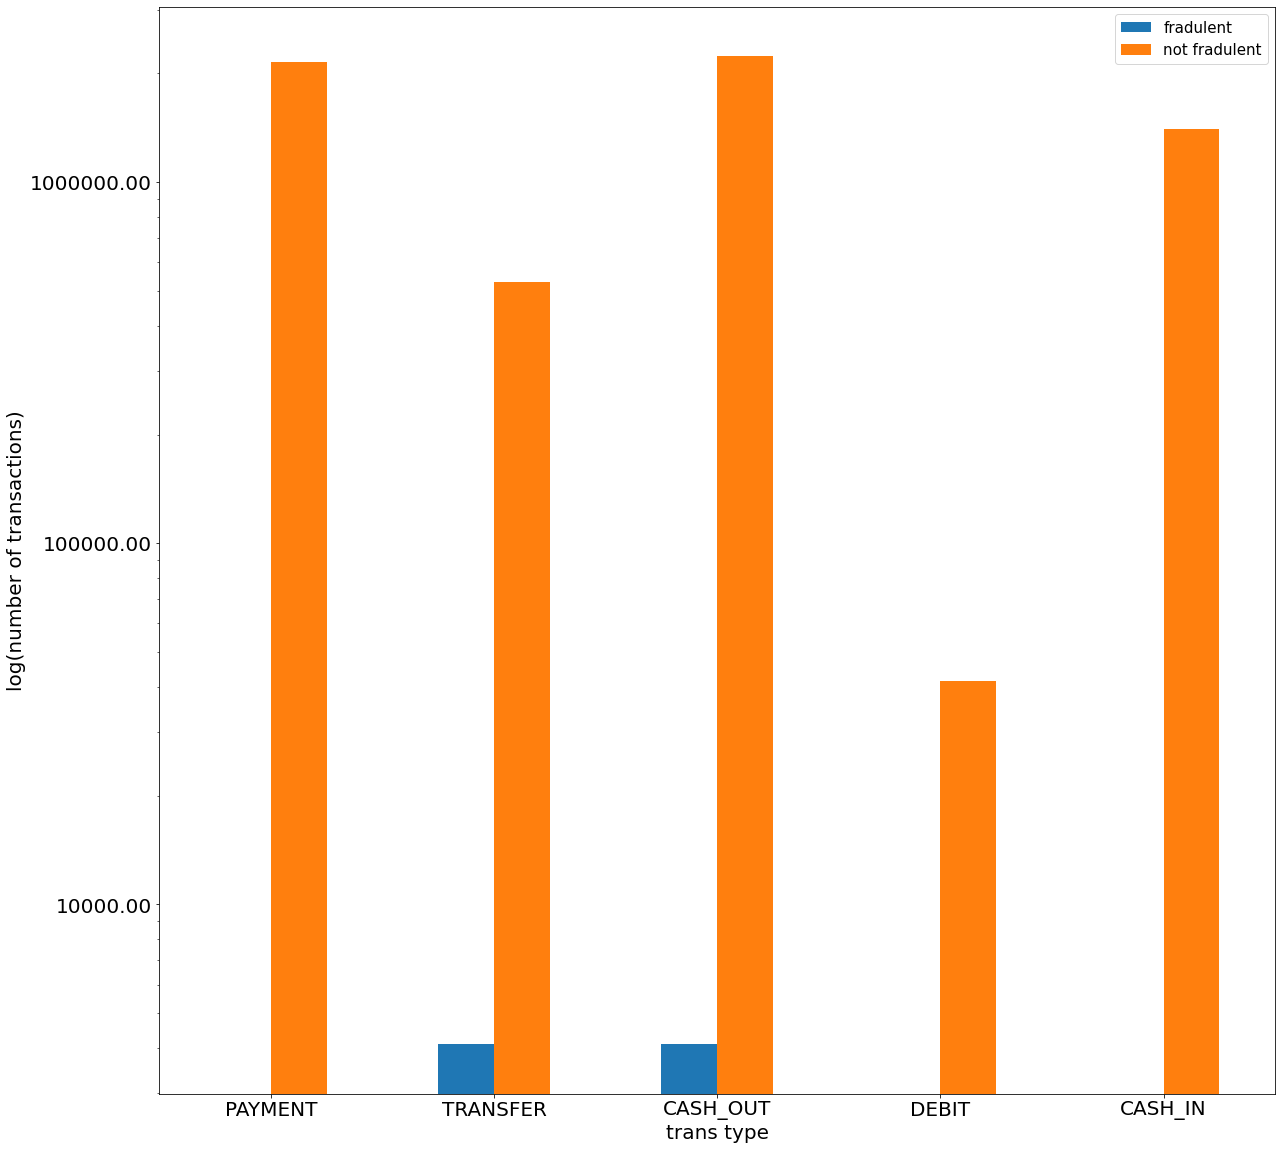

In [25]:
from matplotlib import ticker
thefinal_dict = dict(zip(col_names,rows))

myplot_df = pd.DataFrame(thefinal_dict)
myplot_df = myplot_df.set_index("type")
myplot_df.plot(kind='bar',figsize=(20,20),logy=True,fontsize=20)
#plt.figure(figsize=(20,20))
plt.ylabel("log(number of transactions)",fontsize=20)
plt.xlabel("trans type",fontsize=20)
plt.legend(["fradulent","not fradulent"],fontsize=15)
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.gca().xaxis.set_tick_params(rotation=0)
plt.savefig('fraud_not_fraud_per_xfer.png')

What I get from this graph (TODO elaborate before final version)
* There are several orders of magnitude more `isFraud==0` transactions than `isFraud==1` transactions
* All `isFraud==1` transactions are either `TRANSFER` or `CASH_OUT` transaction types

In [26]:
start_time = datetime.datetime.now()

#TODO If you have time - convert it to a SQL query
pandarallel.initialize()

def calc_suspect(row):
    if ((row["oldbalanceOrg"] == row["amount"]) or (row["newbalanceDest"] == row["amount"])) and (row["newbalanceOrig"] == 0):
        return 1.0
    elif ((row["oldbalanceOrg"] == row["amount"]) or (row["newbalanceDest"] == row["amount"])) and (row["newbalanceOrig"] < row["oldbalanceOrg"]):
        return 0.6
    elif (row["amount"] <= 10000000) and (row["transtype"] == "TRANSFER" or row["transtype"] == "CASH_OUT"):
        return 0.1
    else:
        return 0

paysim_data_df["suspect_score"] = paysim_data_df.parallel_apply(calc_suspect,axis=1)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:14.286600


In [27]:
# Saving the DF to a pickle just in case I can't speed it up
#PICKLE_FILE = open("paysim_data_df.pkl","wb")
##pickle.dump(paysim_data_df,PICKLE_FILE)
#PICKLE_FILE.close()
# X axis 
#


In [28]:
paysim_data_df.head()

,id,step,transtype,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,suspect_score
0,1,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0.0
1,2,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0.0
2,3,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1.0
3,4,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1.0
4,5,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0.0


In [29]:
paysim_data_df.shape

(6362621, 13)

In [30]:
#generating the graph takes a long time will uncomment before publishing it
#sns.scatterplot('transtype', 'suspect_score', data=paysim_data_df, hue='isFraud',
#           palette='Set2', alpha=0.2)
#plt.gcf().set_size_inches(12,8);

So there are still `isFraud==1` transfers with `suspect_score==0`. What are those transactions?

In [31]:
mask = (paysim_data_df["isFraud"] == 1) & (paysim_data_df["suspect_score"] == 0)
paysim_data_df[mask].head(20)

,id,step,transtype,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,suspect_score


OK I should set my limit to `<=` for `amount` doing that above

In [32]:
paysim_data_df[mask].shape

(0, 13)

one-hot-encoding `type`

In [33]:
ohe = OneHotEncoder(sparse=False)

np_data_type = np.array(paysim_data_df["transtype"])
np_data_type = np_data_type.reshape(-1,1)
np_data_type.shape



(6362621, 1)

In [34]:
np_data_type_ohe = ohe.fit_transform(np_data_type)
np_data_type_ohe.shape

(6362621, 5)

In [35]:
np_data_type_ohe_df= pd.DataFrame(np_data_type_ohe,
                           columns=ohe.get_feature_names(['transtype']), #create meaningful column names
                           index=paysim_data_df.index) #keep the same index values

#np_data_type_ohe_df.head()

#combine continuous and categorical data

paysim_data_df = pd.concat([paysim_data_df, np_data_type_ohe_df], axis=1)
paysim_data_df.head()

,id,step,transtype,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,suspect_score,transtype_CASH_IN,transtype_CASH_OUT,transtype_DEBIT,transtype_PAYMENT,transtype_TRANSFER
0,1,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1.0,0.0,0.0,0.0,0.0,1.0
3,4,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1.0,0.0,1.0,0.0,0.0,0.0
4,5,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


A plot to help me understand how mixed together `isFraud==0` is with `isFraud==1` as a function of `type` and `amount`

In [36]:
#NUM_OF_RANDOM_
S = 6000

#plot_data_df = data_df[["step","isFraud","amount","type_CASH_IN","type_CASH_OUT","type_DEBIT","type_PAYMENT","type_TRANSFER"]]
#limit to the first time step
#plot_data_df = plot_data_df[ plot_data_df["step"] == 1 ]
#np_plot_data_df_indices = list(np.random.permutation(np.array(list(plot_data_df.index)))[:5000])
#sns.pairplot(plot_data_df.iloc[[np_plot_data_df_indices]], hue='isFraud');

In [37]:
#This code is generating the index numbers for data frame plot_data_df
#then randomizing the list containing those indices
#then picking the first NUM_OF_RANDOM_SAMPLES from that list
#this list of randomly picked indices will be used to pick the corresponding
#rows out of plot_data_df to be used in the pair plot
#to plot all 6M rows is not practical (on this machine) 
#plot_data_df_indices = list(plot_data_df.index)
#plot_data_df_indices = np.random.permutation(plot_data_df_indices)
#plot_data_df_indices = plot_data_df_indices[:NUM_OF_RANDOM_SAMPLES]
#plot_data_df_indices = list(plot_data_df_indices)


In [38]:
#plot_data_df = plot_data_df.iloc[plot_data_df_indices]

In [39]:
#plot_data_df.shape

In [40]:
#plot_data_df.head()

In [41]:
#sns.pairplot(plot_data_df, hue='isFraud');

Not looking like good parameters :(

## Baseline Model

Random Guessing (50% chance of `isFraud==1` and 50% chance that `isFraud==0` will be the baseline model

In [42]:
paysim_data_df.shape

(6362621, 18)

In [43]:
X = paysim_data_df[["step","amount","transtype_CASH_IN","transtype_CASH_OUT","transtype_DEBIT","transtype_PAYMENT","transtype_TRANSFER"]]
Y = paysim_data_df["isFraud"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

number_of_test_samples = X_test.shape[0]
y_pred_zero = np.zeros(number_of_test_samples // 2)
y_pred_one = np.ones( number_of_test_samples -  y_pred_zero.shape[0] )

y_pred = np.concatenate((y_pred_zero, y_pred_one),axis=0)
y_pred = y_pred.reshape(-1,)
y_pred = np.random.permutation(y_pred)


#print(type(y_pred))
#print(type(Y_test))
Y_test.shape, y_pred.shape,X_test.shape,y_pred_zero.shape,y_pred_one.shape

((636263,), (636263,), (636263, 7), (318131,), (318132,))

Scoring the baseline model

In [44]:
target_names = ["NotFraud","Fraud"]

print(classification_report(Y_test, y_pred,target_names=target_names))

              precision    recall  f1-score   support

    NotFraud       1.00      0.50      0.67    635439
       Fraud       0.00      0.50      0.00       824

    accuracy                           0.50    636263
   macro avg       0.50      0.50      0.33    636263
weighted avg       1.00      0.50      0.67    636263



Thoughts about random guessing model:

Precision (TP/(TP+FP)) and recall (TP/(TP+FN)) are high for the `NotFraud` class because most (99.97%) of the response variables in the test set are `NotFraud`. Precision and recall are very low for `Fraud` because there are very few chances to guess right and the random guessing model does not perform well in identifying them.

Accuracy is meaningless for the same reason: It's easy to get 50% right as the vast majority of the results belong to one class. 

TODO: generate confusion matrix which will help illustrate this.

## Model Selection

Just some notes about what model to select:

**Logistic Models**
For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.



### Modeling Ideas

Try these:

* use stratified train/val/test split
* use over sampling
* use SMOTE
* use ADASYN

* I'm thinking a logistic model will work as it's a binary classification that we're trying to do. Try to ensemble this model if required
* If that doesn't work try a gradient boosted model (of logistic models)
* Do a grid search to find the right hyper parameters


In [45]:
#Since I'm using values that are either 1 or 0 along with amount which is a very large number, will normalize the data
#to aid gradient descent
normalizer = StandardScaler()
X_train_normal = normalizer.fit_transform(X_train.values)
X_test_normal = normalizer.transform(X_test.values)


X_train_normal = pd.DataFrame(X_train_normal)
X_test_normal = pd.DataFrame(X_test_normal)
Y_train = pd.DataFrame(Y_train)
#before running on the gpu I need to convert the pd df's to cudf df's
X_train_norm_cdf = cudf.from_pandas(X_train_normal)
X_test_norm_cdf = cudf.from_pandas(X_test_normal)
Y_train_cdf = cudf.from_pandas(Y_train)



In [46]:
#logisticRModel = LogisticRegressionCV(Cs=100,cv=5,solver="sag",n_jobs=-1,random_state=RANDOM_STATE)
##logisticRModel = LogisticRegression(C=100,solver="sag",n_jobs=-1,random_state=RANDOM_STATE)
logisticRModel = gpuLogisticRegression(C=100.0,max_iter=2000)

start_time = datetime.datetime.now()
logisticRModel.fit(X_train_norm_cdf,Y_train_cdf)
end_time = datetime.datetime.now()
print("training time is {}".format(end_time - start_time))

training time is 0:00:00.486165


In [47]:
Y_pred = logisticRModel.predict(X_test_norm_cdf)
type(Y_pred)

cudf.core.series.Series

In [48]:
Y_pred = Y_pred.to_pandas()
Y_pred = np.array(Y_pred)
print(type(Y_pred),Y_pred.shape)
print(classification_report(Y_test, Y_pred,target_names=target_names))

<class 'numpy.ndarray'> (636263,)
              precision    recall  f1-score   support

    NotFraud       1.00      1.00      1.00    635439
       Fraud       0.00      0.00      0.00       824

    accuracy                           1.00    636263
   macro avg       0.50      0.50      0.50    636263
weighted avg       1.00      1.00      1.00    636263



A small logistic model doesn't do any better than random guessing.

In [49]:
logisticRModel.score(X_test_normal,Y_test)

0.9987033605575562

In [50]:
Y_test.value_counts()

0    635439
1       824
Name: isFraud, dtype: int64

In [51]:
#Y_pred_df = pd.DataFrame(Y_pred)
Y_pred_df = pd.DataFrame(Y_pred)
Y_pred_df.value_counts()

0    636262
1         1
dtype: int64

In [52]:
logisticRModel.coef_

0    0.659883
1    0.056076
2    0.634798
3    1.564377
4    0.122446
5    0.721205
6    1.304417
dtype: float64

Thoughts about baseline logistic model:

Precision (TP/(TP+FP)) and recall (TP/(TP+FN)) are high for the `NotFraud` because most(99.97%) of the response variables in the test set are `NotFraud`. Precision and recall are very low for `Fraud` because there are very few chances to guess right and the random guessing model does not perform well in identify them.

Accuracy is meaningless for the same reason: It's easy to get 50% right as the vast majority of the results belong to one class. 

TODO: generate confusion matrix which will help illustrate this.

### Bigger Logistic Model
Building a model that includes more features, including the engineered feature `suspect_score`


In [53]:
X = paysim_data_df[["step","amount","oldbalanceOrg",
                      "newbalanceOrig",
                      "oldbalanceDest",
                      "newbalanceDest",
                      "suspect_score",
                      "transtype_CASH_IN",
                      "transtype_CASH_OUT",
                      "transtype_DEBIT",
                      "transtype_PAYMENT",
                      "transtype_TRANSFER"]]
Y = paysim_data_df["isFraud"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_train_normal = normalizer.fit_transform(X_train.values)
X_test_normal = normalizer.transform(X_test.values)


In [54]:
#before running on the gpu I need to convert the pd df's to cudf df's
X_train_normal = pd.DataFrame(X_train_normal)
X_test_normal = pd.DataFrame(X_test_normal)
Y_train = pd.DataFrame(Y_train)
X_train_norm_cdf = cudf.from_pandas(X_train_normal)
X_test_norm_cdf = cudf.from_pandas(X_test_normal)
Y_train_cdf = cudf.from_pandas(Y_train)

In [55]:
logisticRModel2 = gpuLogisticRegression(C=100.0,max_iter=2000)

start_time = datetime.datetime.now()
logisticRModel2.fit(X_train_norm_cdf,Y_train_cdf)
end_time = datetime.datetime.now()
print("training time is {}".format(end_time - start_time))

training time is 0:00:00.187838


In [56]:
Y_pred = logisticRModel2.predict(X_test_norm_cdf)

In [57]:
Y_pred = Y_pred.to_pandas()
Y_pred = np.array(Y_pred)
print(type(Y_pred),Y_pred.shape)

<class 'numpy.ndarray'> (636263,)


In [58]:

print(classification_report(Y_test, Y_pred,target_names=target_names))

              precision    recall  f1-score   support

    NotFraud       1.00      1.00      1.00    635439
       Fraud       0.92      0.15      0.25       824

    accuracy                           1.00    636263
   macro avg       0.96      0.57      0.63    636263
weighted avg       1.00      1.00      1.00    636263



Recall and F1 for the `isFraud==1` class has improved. But I will try the following to see if I can improve further:
* oversampling
* SMOTE/ADASYN
* Boosted model

### Oversampling

In [59]:
oversampler = RandomOverSampler(random_state=RANDOM_STATE)


X_resampled, Y_resampled = oversampler.fit_sample(X,Y)




In [60]:
X.shape

(6362621, 12)

In [61]:
Y.shape

(6362621,)

In [62]:
X_resampled.shape

(12708816, 12)

In [63]:
Y_resampled.shape

(12708816,)

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled,test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_train_normal = normalizer.fit_transform(X_train.values)
X_test_normal = normalizer.transform(X_test.values)


In [65]:
#before running on the gpu I need to convert the pd df's to cudf df's
X_train_normal = pd.DataFrame(X_train_normal)
X_test_normal = pd.DataFrame(X_test_normal)
Y_train = pd.DataFrame(Y_train)
X_train_norm_cdf = cudf.from_pandas(X_train_normal)
X_test_norm_cdf = cudf.from_pandas(X_test_normal)
Y_train_cdf = cudf.from_pandas(Y_train)

In [66]:
logisticRModel3 = gpuLogisticRegression(C=100.0,max_iter=2000)

start_time = datetime.datetime.now()
logisticRModel3.fit(X_train_norm_cdf,Y_train_cdf)
end_time = datetime.datetime.now()
print("training time is {}".format(end_time - start_time))

training time is 0:00:00.312225


In [67]:
Y_pred = logisticRModel3.predict(X_test_norm_cdf)


In [68]:
Y_pred = Y_pred.to_pandas()
Y_pred = np.array(Y_pred)
print(type(Y_pred),Y_pred.shape)

<class 'numpy.ndarray'> (1270882,)


In [69]:
print(classification_report(Y_test, Y_pred,target_names=target_names))

              precision    recall  f1-score   support

    NotFraud       0.99      0.96      0.98    635907
       Fraud       0.96      0.99      0.98    634975

    accuracy                           0.98   1270882
   macro avg       0.98      0.98      0.98   1270882
weighted avg       0.98      0.98      0.98   1270882



### SMOTE


In [70]:
smoter = SMOTE(random_state=RANDOM_STATE)
X_smoted,Y_smoted = smoter.fit_sample(X,Y)


In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X_smoted, Y_smoted,test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_train_normal = normalizer.fit_transform(X_train.values)
X_test_normal = normalizer.transform(X_test.values)


In [72]:
#before running on the gpu I need to convert the pd df's to cudf df's
X_train_normal = pd.DataFrame(X_train_normal)
X_test_normal = pd.DataFrame(X_test_normal)
Y_train = pd.DataFrame(Y_train)
X_train_norm_cdf = cudf.from_pandas(X_train_normal)
X_test_norm_cdf = cudf.from_pandas(X_test_normal)
Y_train_cdf = cudf.from_pandas(Y_train)

In [73]:
logisticRModel4 = gpuLogisticRegression(C=100.0,max_iter=2000)
start_time = datetime.datetime.now()
logisticRModel4.fit(X_train_norm_cdf,Y_train_cdf)
end_time = datetime.datetime.now()
print("training time is {}".format(end_time - start_time))

training time is 0:00:00.272704


In [74]:
Y_pred = logisticRModel4.predict(X_test_norm_cdf)



In [75]:
Y_pred = Y_pred.to_pandas()
Y_pred = np.array(Y_pred)
print(type(Y_pred),Y_pred.shape)

<class 'numpy.ndarray'> (1270882,)


In [76]:
print(classification_report(Y_test, Y_pred,target_names=target_names))

              precision    recall  f1-score   support

    NotFraud       1.00      0.95      0.97    635907
       Fraud       0.96      1.00      0.97    634975

    accuracy                           0.97   1270882
   macro avg       0.98      0.97      0.97   1270882
weighted avg       0.98      0.97      0.97   1270882



### ADASYN

In [77]:
# ADASYN is a KNN-based synthesizer
# These are O(n^2) algorithms so with 6M initial samples I don't think it's practical to run
# this for this data set
#
#adasynthesizer = ADASYN(random_state=RANDOM_STATE)
#X_adasyn, Y_adasyn = adasynthesizer.fit_sample(X,Y)


In [78]:
#X_train, X_test, Y_train, Y_test = train_test_split(X_adasyn, Y_adasyn,test_size=TEST_SIZE, random_state=RANDOM_STATE)
#X_train_normal = normalizer.fit_transform(X_train.values)
#X_test_normal = normalizer.transform(X_test.values)

In [79]:
#before running on the gpu I need to convert the pd df's to cudf df's
#X_train_normal = pd.DataFrame(X_train_normal)
#X_test_normal = pd.DataFrame(X_test_normal)
#Y_train = pd.DataFrame(Y_train)
#X_train_norm_cdf = cudf.from_pandas(X_train_normal)
#X_test_norm_cdf = cudf.from_pandas(X_test_normal)
#Y_train_cdf = cudf.from_pandas(Y_train)

In [80]:
#logisticRModel5 = LogisticRegression(C=100.0,max_iter=200,n_jobs=-1,random_state=RANDOM_STATE)

#start_time = datetime.datetime.now()
#logisticRModel5.fit(X_train_normal,Y_train)
#end_time = datetime.datetime.now()
#print("training time is {}".format(end_time - start_time))

In [81]:
#Y_pred = logisticRModel5.predict(X_test_normal)

#print(classification_report(Y_test, Y_pred,target_names=target_names))

## Model Evaluation

I will do this:
* Create a test set from the original data set (with one-hot encoding and the `suspect_score` feature)
* Create ROC Curves for the models
* Calc AUC for the models

### Test set from the original dataset

In [145]:
X = paysim_data_df[["step","amount","oldbalanceOrg",
                      "newbalanceOrig",
                      "oldbalanceDest",
                      "newbalanceDest",
                      "suspect_score",
                      "transtype_CASH_IN",
                      "transtype_CASH_OUT",
                      "transtype_DEBIT",
                      "transtype_PAYMENT",
                      "transtype_TRANSFER"]]
Y = paysim_data_df["isFraud"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_train_normal = normalizer.fit_transform(X_train.values)
X_test_normal = normalizer.transform(X_test.values)

In [146]:
#before running on the gpu I need to convert the pd df's to cudf df's
X_train_normal = pd.DataFrame(X_train_normal)
X_test_normal = pd.DataFrame(X_test_normal)
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)
X_train_norm_cdf = cudf.from_pandas(X_train_normal)
X_test_norm_cdf = cudf.from_pandas(X_test_normal)
Y_train_cdf = cudf.from_pandas(Y_train)
Y_test_cdf = cudf.from_pandas(Y_test)

In [147]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((5726358, 12), (636263, 12), (5726358, 1), (636263, 1))

In [148]:
Y_test.value_counts()

isFraud
0          635439
1             824
dtype: int64

In [149]:
Y.value_counts()

0    6354408
1       8213
Name: isFraud, dtype: int64

As you can see the test set has a few `isFraud==1` much like the full data set

### Random Guessing and Small Logistic Model

### Random Oversampled Model

In [150]:
Y_pred = logisticRModel3.predict(X_test_norm_cdf)
Y_pred = Y_pred.to_pandas()
Y_pred = np.array(Y_pred)
print(type(Y_pred),Y_pred.shape)
print(classification_report(Y_test, Y_pred,target_names=target_names))


<class 'numpy.ndarray'> (636263,)
              precision    recall  f1-score   support

    NotFraud       1.00      0.54      0.70    635439
       Fraud       0.00      1.00      0.01       824

    accuracy                           0.54    636263
   macro avg       0.50      0.77      0.35    636263
weighted avg       1.00      0.54      0.70    636263



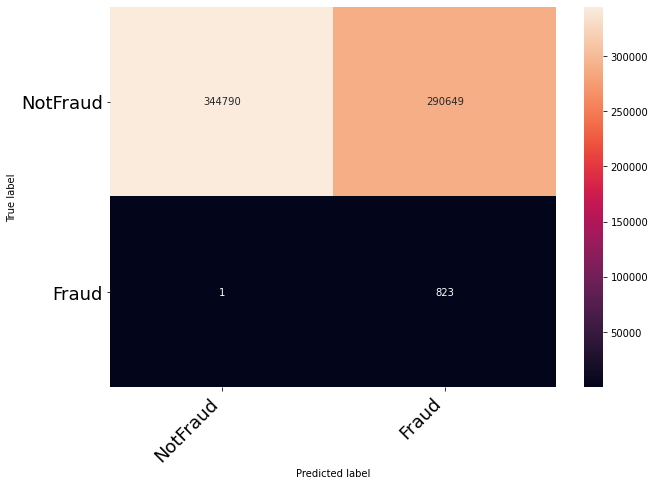

In [151]:
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
cm = print_confusion_matrix(conf_matrix,target_names)

In [152]:
Y_pred_prob = logisticRModel3.predict_proba(X_test_norm_cdf)
Y_pred_prob = Y_pred_prob.to_pandas()
Y_pred_prob = np.array(Y_pred_prob)
precision_curve, recall_curve, threshold_curve = precision_recall_curve(Y_test, Y_pred_prob[:,1] )


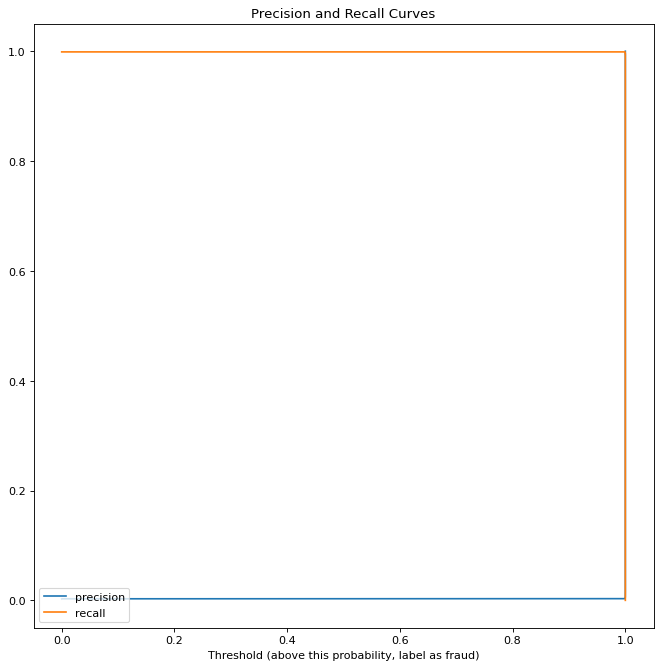

In [153]:
plt.figure(figsize=(10,10),dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [154]:
Y_pred = logisticRModel4.predict(X_test_norm_cdf)
Y_pred = Y_pred.to_pandas()
Y_pred = np.array(Y_pred)
print(classification_report(Y_test, Y_pred,target_names=target_names))

              precision    recall  f1-score   support

    NotFraud       1.00      0.55      0.71    635439
       Fraud       0.00      1.00      0.01       824

    accuracy                           0.55    636263
   macro avg       0.50      0.77      0.36    636263
weighted avg       1.00      0.55      0.71    636263



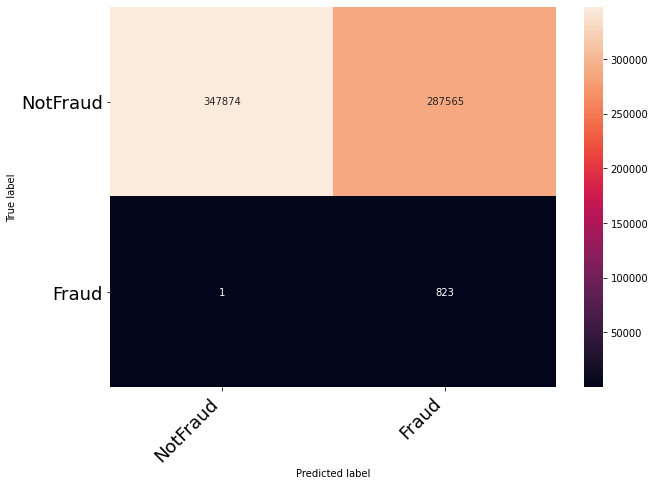

In [155]:
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
cm = print_confusion_matrix(conf_matrix,target_names)

**Thoughts**
* Logistic models are not performing well. Will move on to Random Forest and XGBoost

In [156]:
randforestModel = gpuRandomForestClassifier()

#The cuML framework doesn't support prediction on 64-bit floating point
#numbers for this model so converting the dataset to 32-bit floating point numbers
X_train_norm_cdf = X_train_norm_cdf.astype(cnp.float32)
Y_train_cdf = Y_train_cdf.astype(cnp.float32)

randforestModel.fit(X_train_norm_cdf,Y_train_cdf)

RandomForestClassifier(split_criterion=0, handle=<cuml.raft.common.handle.Handle object at 0x7f3432cf4ed0>, verbose=4, output_type='cudf')

In [157]:
Y_pred = randforestModel.predict(X_test_norm_cdf)
Y_pred = Y_pred.to_pandas()
Y_pred = np.array(Y_pred)
print(classification_report(Y_test, Y_pred,target_names=target_names))

              precision    recall  f1-score   support

    NotFraud       1.00      1.00      1.00    635439
       Fraud       1.00      0.89      0.94       824

    accuracy                           1.00    636263
   macro avg       1.00      0.95      0.97    636263
weighted avg       1.00      1.00      1.00    636263



In [158]:
X_train_norm_cdf.shape

(5726358, 12)

In [159]:
X_test_norm_cdf.shape

(636263, 12)

In [160]:
Y_pred_prob = randforestModel.predict_proba(X_test_norm_cdf)
Y_pred_prob = Y_pred_prob.to_pandas()
Y_pred_prob = np.array(Y_pred_prob)
precision_curve, recall_curve, threshold_curve = precision_recall_curve(Y_test, Y_pred_prob[:,1] )


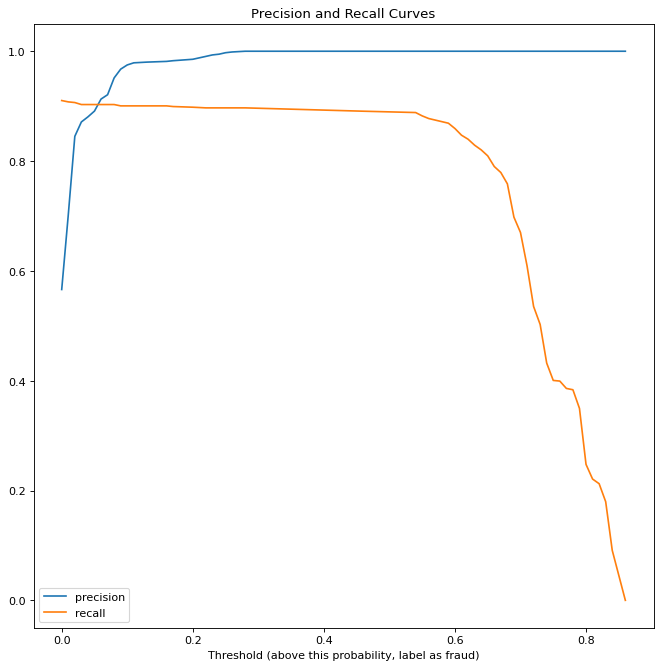

In [161]:
plt.figure(figsize=(10,10),dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

(636263, 1) (636263, 2)
ROC AUC score =  0.9550534215570287


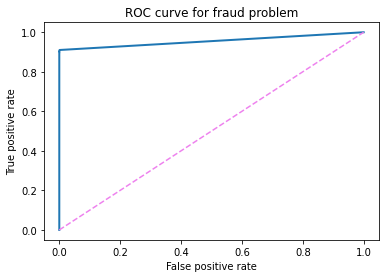

In [162]:
print(Y_test.shape,Y_pred_prob.shape)
FalsePosRate, TruePosRate, Thresh = roc_curve(Y_test, Y_pred_prob[:,1])
plt.plot(FalsePosRate, TruePosRate,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(Y_test, Y_pred_prob[:,1]))

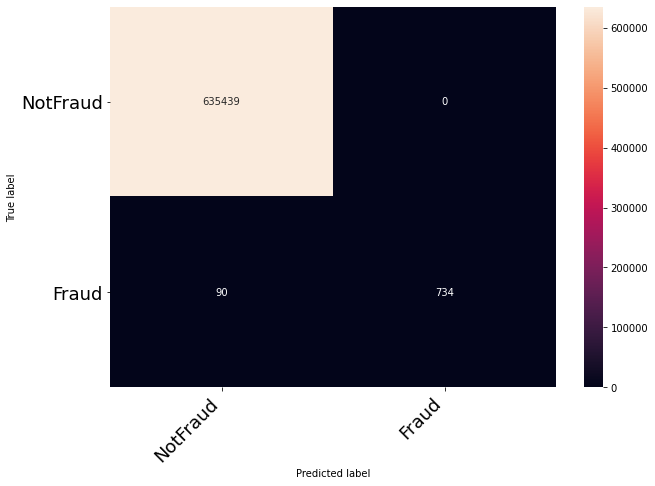

In [163]:
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
cm = print_confusion_matrix(conf_matrix,target_names)

In [164]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_normal,Y_train)
Y_pred = xgb_model.predict(X_test_normal)
print(classification_report(Y_test, Y_pred,target_names=target_names))

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[15:03:15] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1603299467566/work/src/gbm/gbtree.cc:147: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[15:03:18] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1603299467566/work/src/learner.cc:1036: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

    NotFraud       1.00      1.00      1.00    635439
       Fraud       0.99      0.95      0.97       824

    accuracy                           1.00    636263
   macro avg       1.00      0.98      0.99    636263
weighted avg       1.00      1.00      1.00    636263



The best two models are the XGBoost model and the RandomForestClassifier model.

In [165]:
Y_pred_prob = xgb_model.predict_proba(X_test_normal)
precision_curve, recall_curve, threshold_curve = precision_recall_curve(Y_test, Y_pred_prob[:,1] )


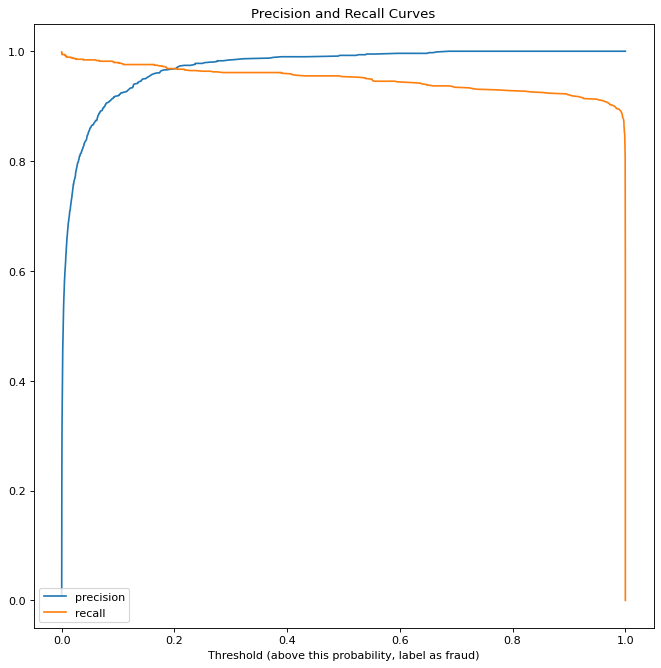

In [166]:
plt.figure(figsize=(10,10),dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

(636263, 1) (636263, 2)
ROC AUC score =  0.9996941950551516


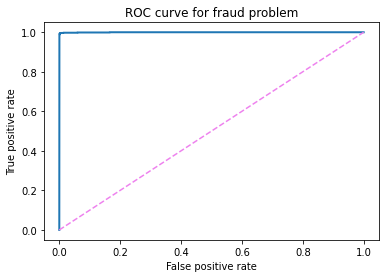

In [167]:
print(Y_test.shape,Y_pred_prob.shape)
FalsePosRate, TruePosRate, Thresh = roc_curve(Y_test, Y_pred_prob[:,1])
plt.plot(FalsePosRate, TruePosRate,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(Y_test, Y_pred_prob[:,1]))

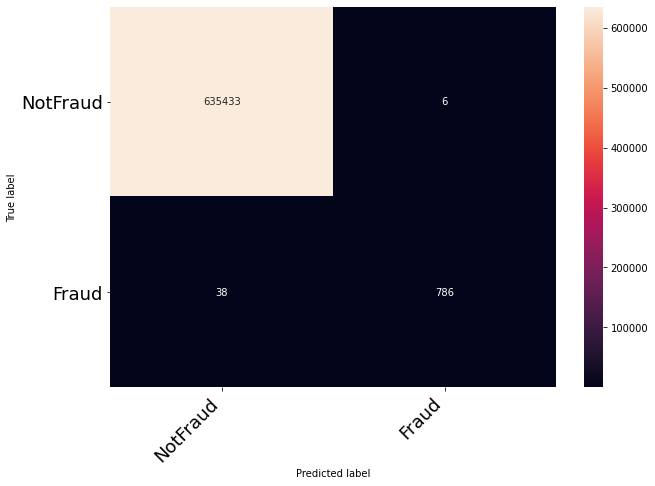

In [168]:
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
cm = print_confusion_matrix(conf_matrix,target_names)

Although the numbers indicate that the XGBoost model is better--its is AUC=0.999 vs the random forest's AUC=0.955--the confusion matrix reviews something that would have to be considered in light of business priorities.

The number of times that the XGBoost model labels something that is not fraud is 6, whereas it's 0 in the random forest model. If the business cost to resolve cases that are falsely labeled as frauds is much greater than the cost to resolve cases that are falsely labeled as not fraud, then the random forest model will be more desirable model from a business standpoint even though it performs better statistically.

Although I would want to seek knowledgeable people in the mobile payments organization to confirm this, I speculate that the converse is true: It's more expensive and harder to catch and resolve cases of fraud that go undetected than to resolve cases that are falsely detected as fraud, especially with a model that falsely labels 6 non-fraudulent cases per 636,263 total cases.